### Ranking mutations by transmissibility

This assumes you've acquired GISAID data and run
```sh
make update               # ~30 minutes on CPU
python rank_mutations.py  # ~30 minutes on GPU
```

In [1]:
import math
import pickle
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.distributions import constraints
from pyrocov import pangolin

matplotlib.rcParams['figure.dpi'] = 200

## Loading data

In [2]:
results = torch.load("results/rank_mutations.pt", map_location="cpu")
print(results.keys())
print("initial_ranks:", results['initial_ranks'].keys())
print("dropout keys:", list(results['dropouts'].keys())[:5], "...")
for fit in results['dropouts'].values(): 
    print("fit[0] keys:", fit.keys())
    print("loss_terms:")
    display(fit['loss_terms'])
    break

dict_keys(['args', 'mutations', 'initial_ranks', 'dropouts'])
initial_ranks: dict_keys(['args', 'mean', 'std', 'ranks', 'cond_data'])
dropout keys: [None, 52, 183, 1918, 162] ...
fit[0] keys: dict_keys(['args', 'mutation', 'mode', 'guide', 'losses', 'loss_terms'])
loss_terms:


{'model': {'feature_scale': -0.9315353035926819,
  'log_rate_coef': -2793.04150390625,
  'log_rate': 0.0,
  'log_init': -902401.0,
  'concentration': -2.7434329986572266,
  'obs': -258131.65625},
 'guide': {'log_rate_coef': 0.0, 'log_init': 0.0}}

## Assessing model accuracy

The inference approach in `rank_mutations.py` is to:
1. Fit a mean-field variational model via stochastic variational inference (SVI).
2. Initially rank mutations by `|mean|/stddev` of their growth rate coefficietns `log_rate_coef`.
3. Fit MAP model parameters via (SVI).
4. For each of most postitive and most negative mutations, fit MAP model parameters with that feature removed.
5. Rank features by the change in loss for base-model versus model-with-feature-removed.

Let's examine the initial versus final ranking metric.

In [3]:
dropouts = results["dropouts"]
initial_ranks = results["initial_ranks"]
mode = dropouts[None]["mode"].detach()
feature_ids = torch.tensor(sorted([k for k in results["dropouts"] if k is not None]))
mode = mode[feature_ids]
mean = initial_ranks["mean"][feature_ids].detach()
sigma = mean / initial_ranks["std"][feature_ids].detach()
log_likelihood = torch.tensor([
    dropouts[i]["loss_terms"]["model"]["obs"] for i in feature_ids.tolist()
])
log_likelihood -= dropouts[None]["loss_terms"]["model"]["obs"]
mutations = [results["mutations"][i] for i in feature_ids.tolist()]

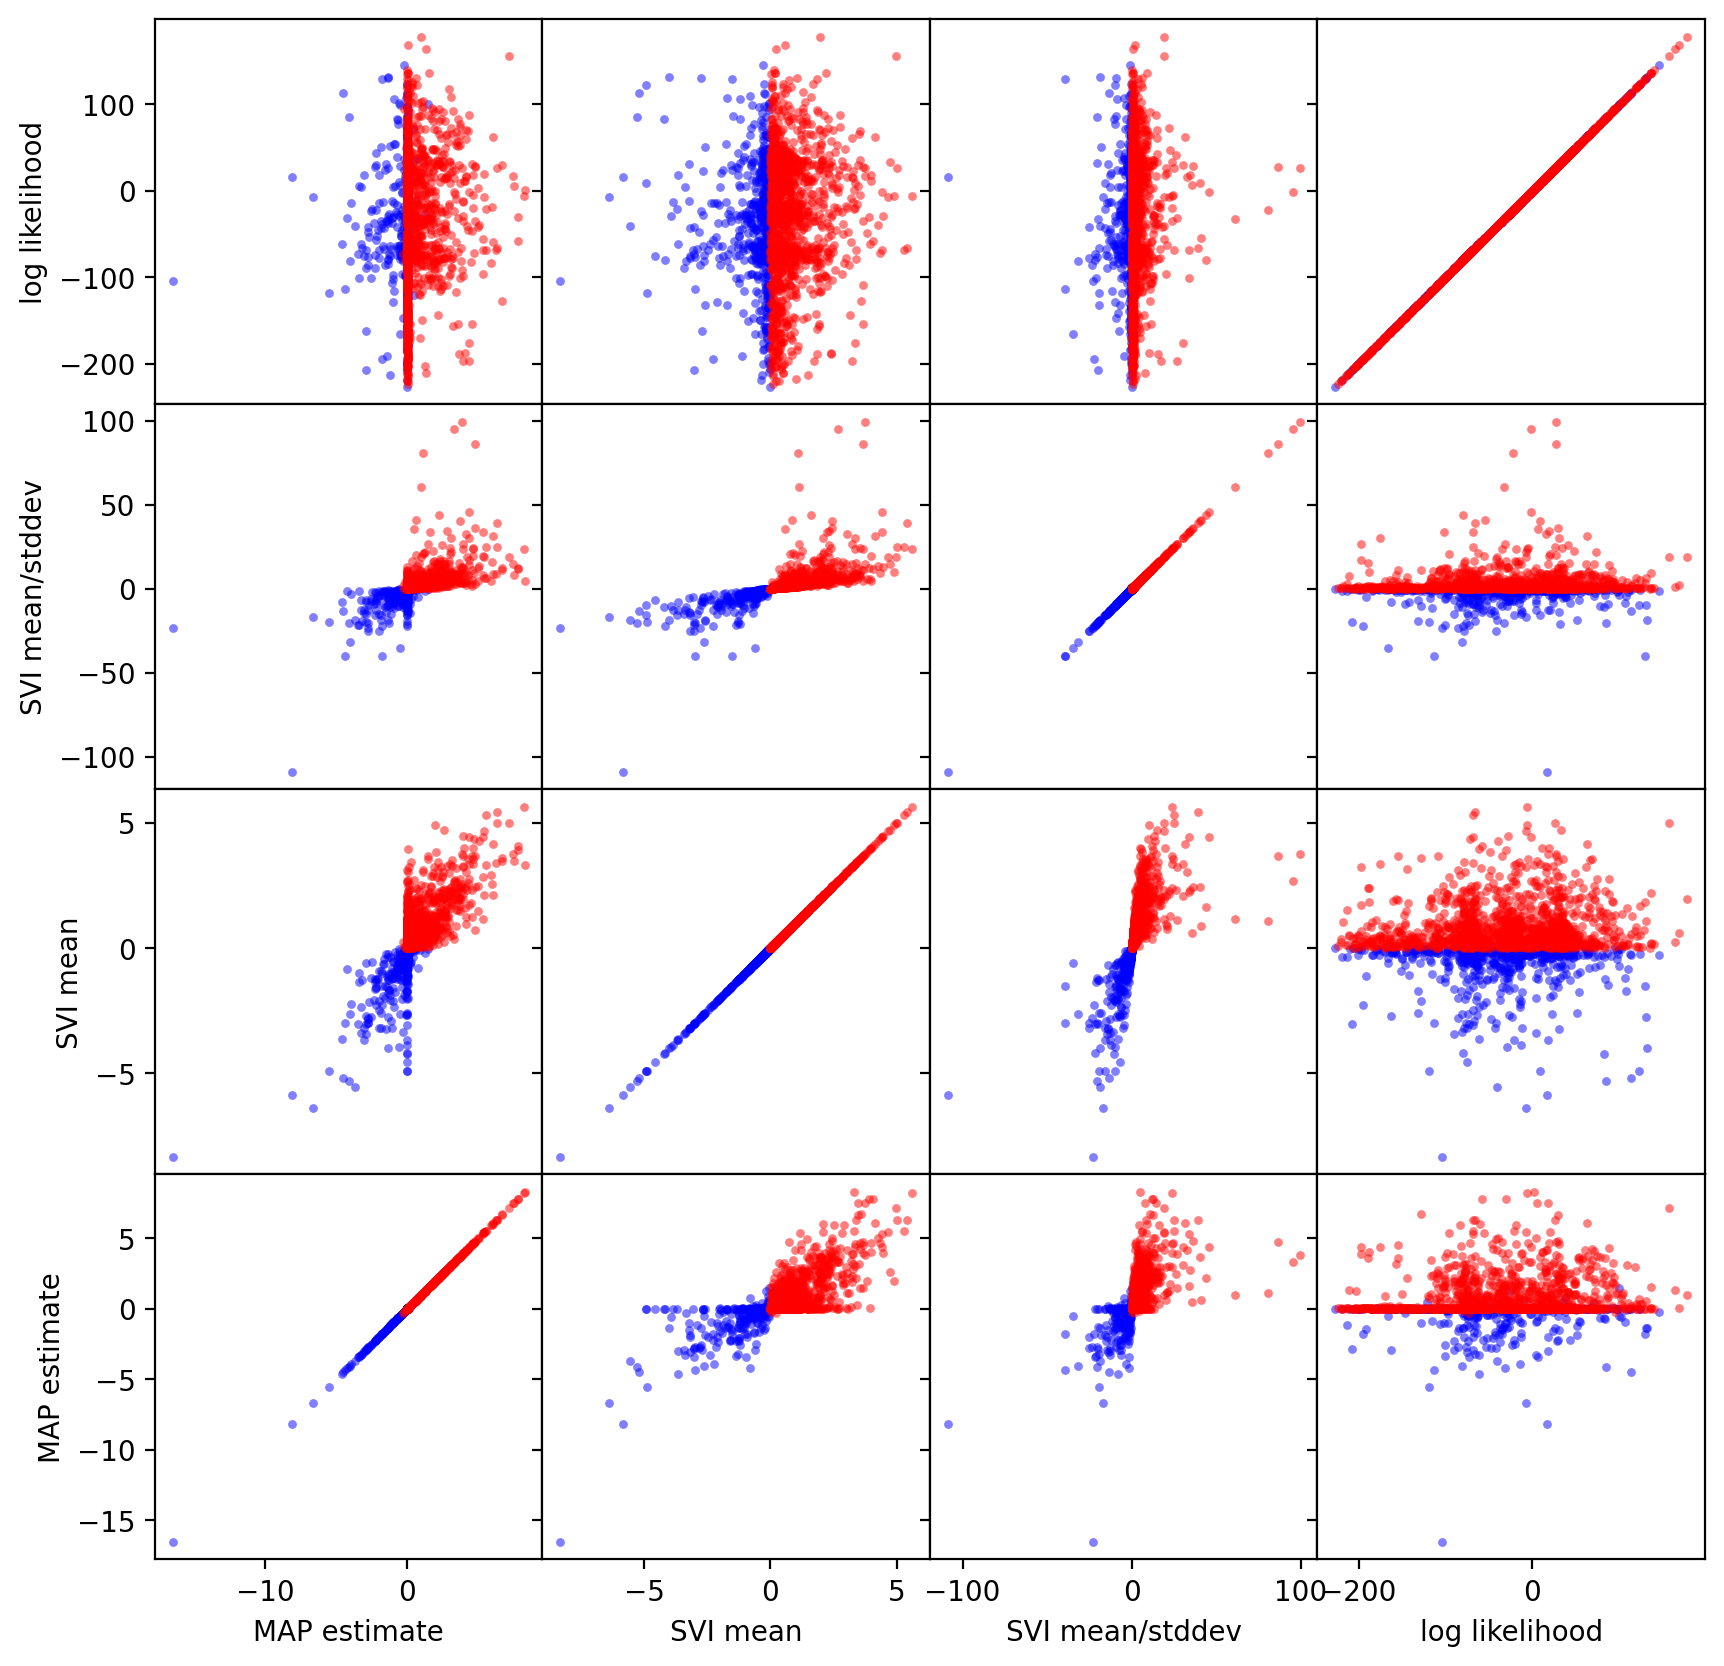

In [4]:
trends = {
    "MAP estimate": mode,
    "SVI mean": mean,
    "SVI mean/stddev": sigma,
    "log likelihood": log_likelihood,
}
pos = mean > 0
fig, axes = plt.subplots(len(trends), len(trends), figsize=(10, 10), sharex="col", sharey="row")
for i, (axes_i, (name_i, trend_i)) in enumerate(zip(axes, reversed(list(trends.items())))):
    axes[i][0].set_ylabel(name_i)
    for j, (ax, (name_j, trend_j)) in enumerate(zip(axes_i, trends.items())):
        axes[-1][j].set_xlabel(name_j)
        ax.scatter(trend_j[~pos].numpy(), trend_i[~pos].numpy(),
                   10, color='blue', alpha=0.5, lw=0)
        ax.scatter(trend_j[pos].numpy(), trend_i[pos].numpy(),
                   10, color='red', alpha=0.5, lw=0)
plt.subplots_adjust(wspace=0, hspace=0)

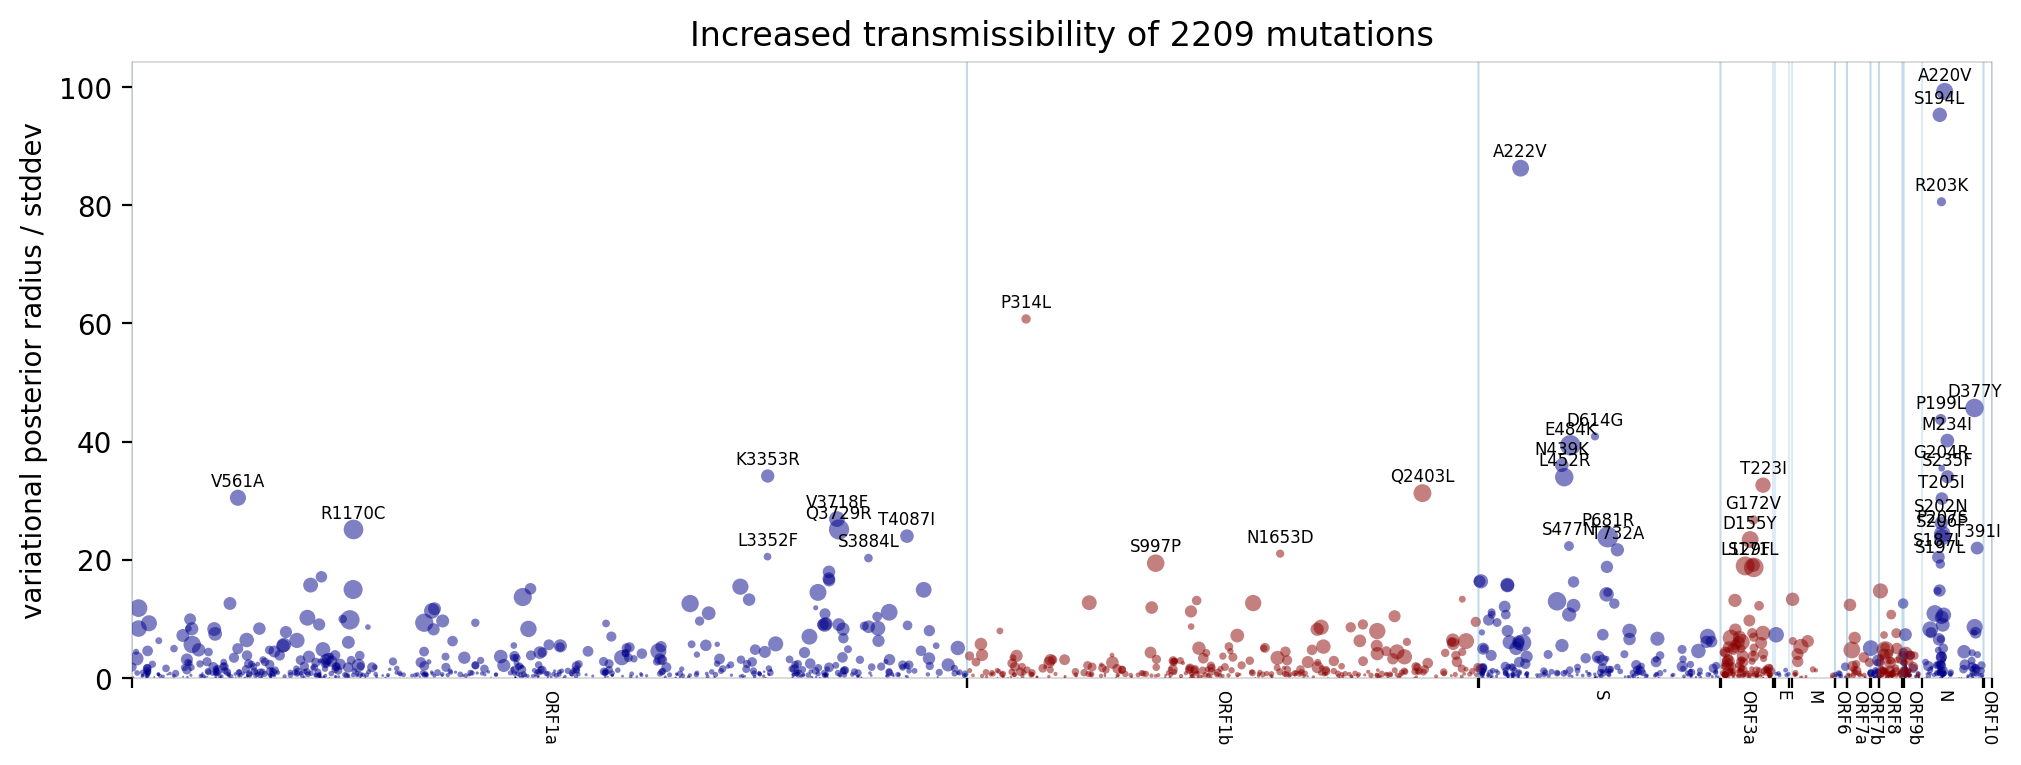

In [13]:
from pyrocov.sarscov2 import GENE_TO_POSITION, aa_mutation_to_position

def plot_manhattan(rankby, radius, top_k=40, in_gene=None):
    y1 = rankby.max().item()
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    assert len(position) == len(radius)
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    even = (gene_ids % 2 == 0) & (radius > 0)
    odd = (gene_ids % 2 == 1) & (radius > 0)

    plt.figure(figsize=(12, 4))
    if in_gene is None:
        plt.title(f"Increased transmissibility of {len(mutations)} mutations")
    else:
        start, end = GENE_TO_POSITION[in_gene]
        num_mutations = sum(1 for p in position.tolist() if start <= p <= end)
        plt.title(f"Increased transmissibility of {num_mutations} mutations in {in_gene} gene")
    for mask, color in zip([even, odd], ["darkblue", "darkred"]):
        plt.scatter(position[mask].numpy(), rankby[mask].numpy(), 10 * radius[mask].numpy(),
                    color=color, alpha=0.5, lw=0)
    for i in rankby.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(rankby[i])
        gene, name = mutations[i].split(":")
        if in_gene in (None, gene):
            plt.text(x, y + y1/80, name, fontsize=6,
                     verticalalignment="bottom", horizontalalignment="center")
        
    if in_gene is None:
        start_end = list(GENE_TO_POSITION.values())
        plt.xlim(start_end[0][0], start_end[-1][-1])
        xticks = []
        for i, (gene, (start, end)) in enumerate(GENE_TO_POSITION.items()):
            if gene == "ORF14":
                continue  # skip overlapping frame
            if in_gene not in (None, gene):
                continue
            plt.axvline(start, lw=0.1)
            plt.axvline(end, lw=0.1)
            xticks.extend([start, end])
            plt.text((start + end) / 2, -y1 / 50, gene, rotation=-90,
                     fontsize=6, verticalalignment="top", horizontalalignment="center")
        plt.xticks(xticks, labels=())
    else:
        start, end = GENE_TO_POSITION[in_gene]
        plt.xlim(start, end)
        xticks = [start]
        while xticks[-1] + 300 < end:
            xticks.append(xticks[-1] + 300)
        labels = [str((x - start) // 3) for x in xticks]
        plt.xticks(xticks, labels)
        plt.xlabel("amino acid position")
    plt.ylim(0, None)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)
    plt.ylabel("variational posterior radius / stddev")

plot_manhattan(sigma, mean)

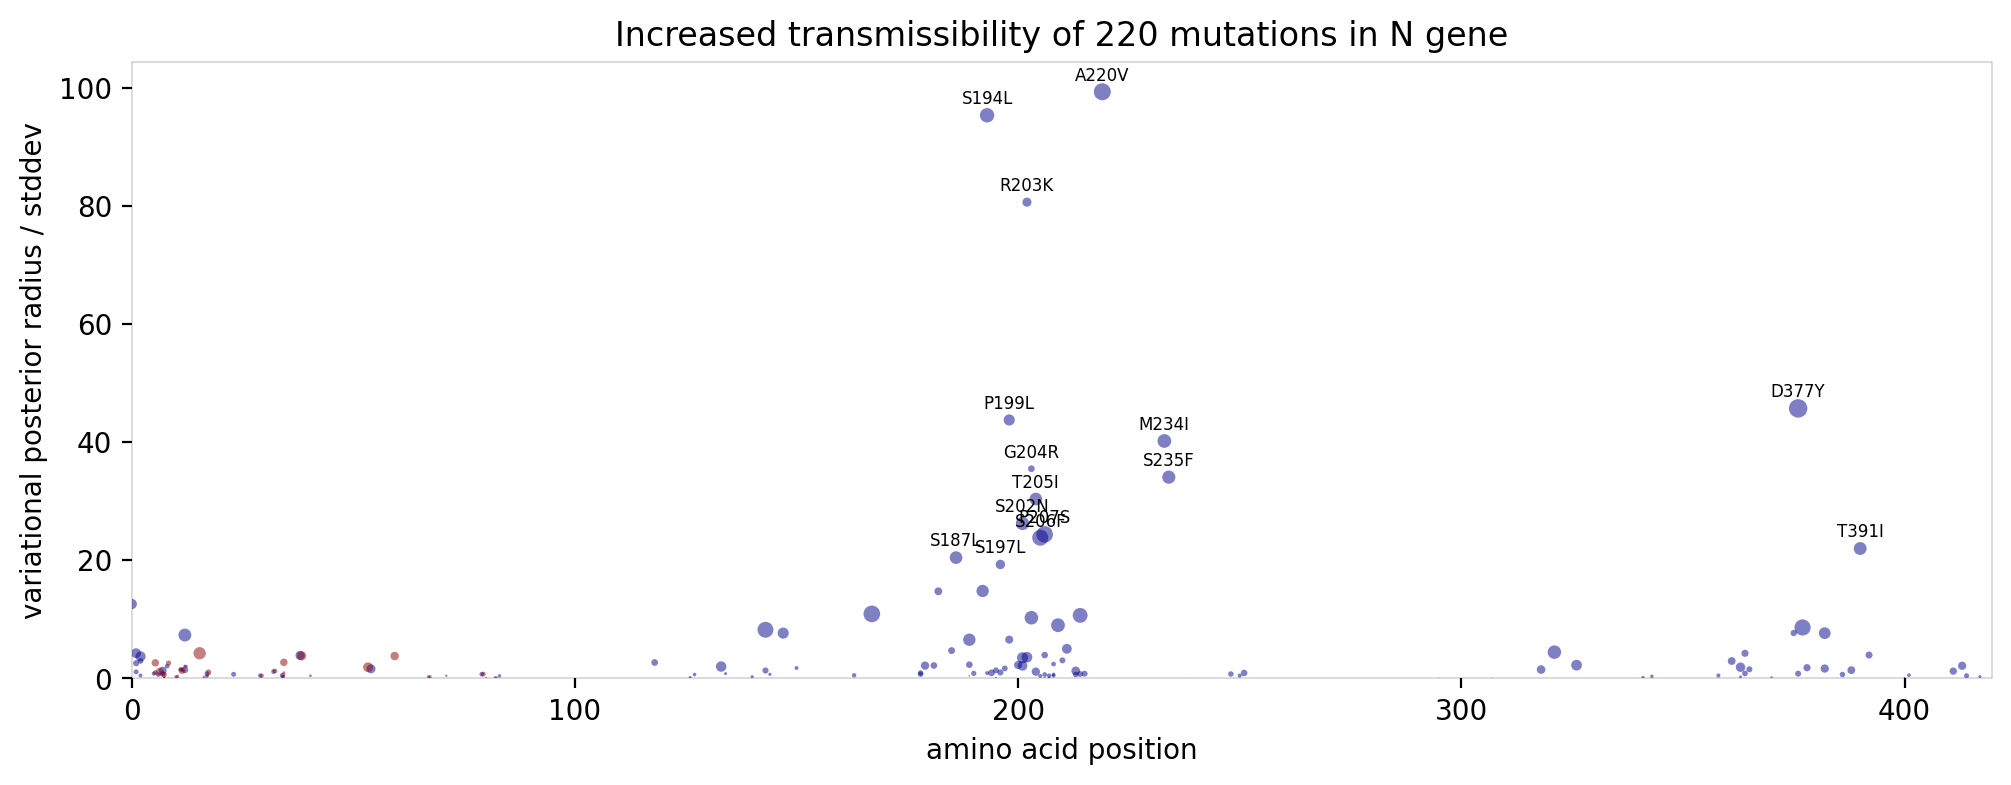

In [14]:
plot_manhattan(sigma, mean, in_gene="N")

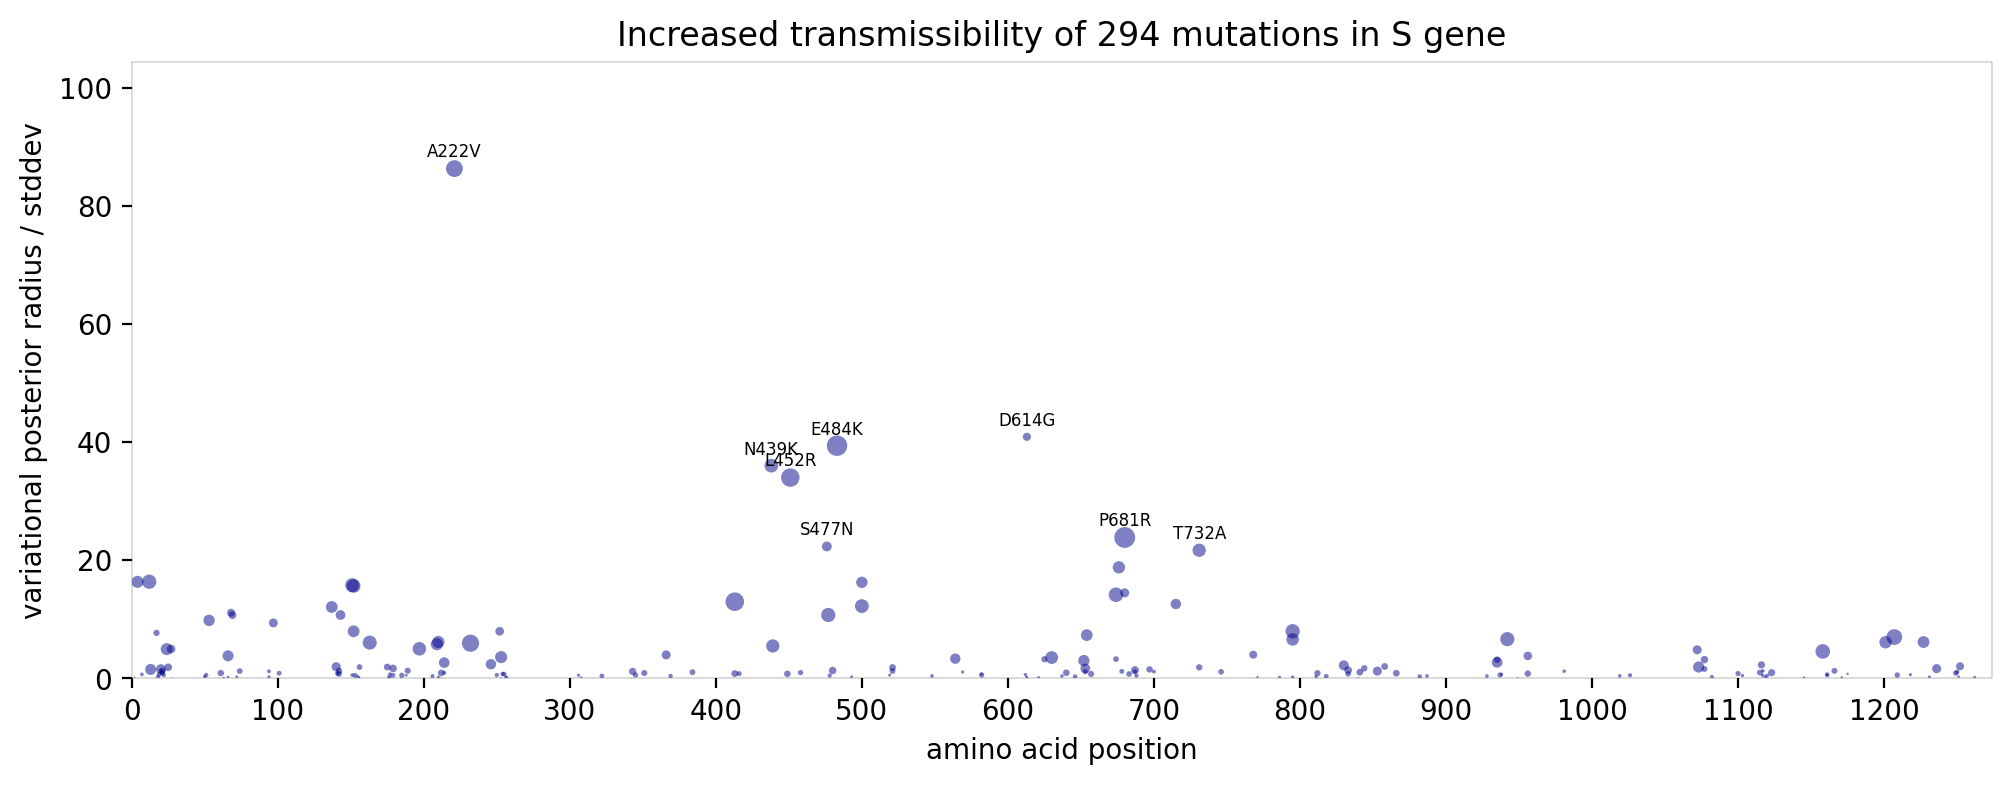

In [15]:
plot_manhattan(sigma, mean, in_gene="S")